In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter

In [39]:
''' defining functions used later within the notebook '''

def str_to_percent(word):
    str_num = re.findall("\d+\.\d+", word)
    if not str_num:
        str_num = re.findall("\d+", word)
    return float(str_num[0]) / 100

def map_hours(df):
    hour_map = {'Not at all': 0, 'Less than 1 hour': 1, '1-2 hours': 2, '3 or more hours': 3}
    df = df.applymap(lambda x: hour_map.get(x) if x in hour_map else x)
    return df

def calc_s(x,y):
    s = Counter(zip(x,y))
    s = [c[(xx,yy)] for xx,yy in zip(x,y)]
    return s

In [3]:
df = pd.read_csv("../data/maps-synthetic-data-v1.1.csv")

In [15]:
df2 = df[['X', 'dep_band_15', 'dep_band_10', 'dep_band_13', 'dep_band_07', 'dep_score', 'comp_week', 'comp_wend', 'tv_week', 'tv_wend']].copy().dropna()

In [16]:
# doesn't work
# dep_bands = ['dep_band_15', 'dep_band_10', 'dep_band_13', 'dep_band_07']
# df2[dep_bands] = df2[dep_bands].apply(str_to_percent)

# Doing each column individually then
df2['dep_band_15'] = df2['dep_band_15'].apply(str_to_percent)
df2['dep_band_13'] = df2['dep_band_13'].apply(str_to_percent)
df2['dep_band_10'] = df2['dep_band_10'].apply(str_to_percent)
df2['dep_band_07'] = df2['dep_band_07'].apply(str_to_percent)

In [17]:
df2 = map_hours(df2)
df2

,X,dep_band_15,dep_band_10,dep_band_13,dep_band_07,dep_score,comp_week,comp_wend,tv_week,tv_wend
0,1,0.005,0.005,0.005,0.005,0.0,2,2,2,2
5,6,0.005,0.001,0.150,0.001,0.0,2,1,2,3
8,9,0.150,0.001,0.001,0.001,0.0,3,3,2,2
33,34,0.150,0.001,0.001,0.005,2.0,2,2,1,2
35,36,0.005,0.150,0.005,0.001,0.0,2,2,2,3
...,...,...,...,...,...,...,...,...,...,...
13671,13672,0.005,0.700,0.150,0.005,0.0,3,3,3,3
13694,13695,0.001,0.001,0.001,0.001,0.0,3,3,1,2
13716,13717,0.005,0.005,0.005,0.005,0.0,3,3,2,3
13720,13721,0.005,0.150,0.001,0.005,0.0,2,3,1,2


In [20]:
df2['screentime'] = df2[['comp_wend', 'comp_week', 'tv_week', 'tv_wend']].sum(axis=1)

<function matplotlib.pyplot.show(close=None, block=None)>

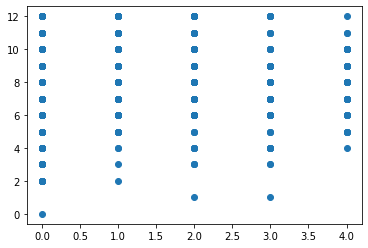

In [24]:
x = df2['dep_score']
y = df2['screentime']
plt.scatter(x, y)
plt.show

[Look into removing columns that aren't useful / are duplicated?

In [9]:
# Unnamed is the same as column X - flag is the same throughout the dataset
del df['Unnamed: 0']
del df['flag']
# Do we need the column X?


KeyError: 'Unnamed: 0'

How do we want to deal with NAN values? Looking into just filling them with 0/False

In [5]:
df = df.fillna(0)

Lot of string values within columns, looking into mapping them to integer values which can be better dealt with

In [6]:
map_list = []

# create a bunch of dictionaries to map value too
'''
    Need to discuss these bindings, some columns use similar but use different generalisations
    Some use '1 or more hours' and some use 'Less than 3 hours'
    Do we want to label these differently?
'''
hours_map = {'Not at all': 0, 'Less than 1 hour': 0, '1-2 hours': 0,
            '3 or more hours': 1, '1 or more hours': 1, 'Less than 3 hours': 0}

purchase_map = {'In her/his room': 1, 'Have in house': 2, 'Bought in last 6 months': 3, 'Intend to buy': 4}
occurance_map = {'Not at all': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3, 'sometimes': 1, 'often': 2}
television_map = {'Don\'t have a T.V.': 0, 'No hardly ever': 1,
                  'Yes Some Days': 1, 'Yes Every Days': 1, 'Any at all': 1}

yes_no_map = {'No': 0, 'Yes': 1}
sex_map = {'Male': 0, 'Female': 1}
# 0 = first born, 1 = other birth
birth_map = {'A': 0, 'B': 1}

# add all the maps to the same list to iterate over
map_list.extend([hours_map, yes_no_map, purchase_map, occurance_map, television_map, sex_map, birth_map])

In [7]:
for mapping in map_list:
    df = df.applymap(lambda x: mapping.get(x) if x in mapping else x)

In [21]:
df

,X,comp_bed_9,mat_dep,mat_age,weight_16,height_16,iq,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,...,dep_score,comp_house,tv_bed_16,creat_14,comp_games,fam_tv_eve,fam_tv_aft,fam_tv_mor,sex,birth_order
0,1,0,3.0,30,59.294132,181.602831,107.0,0,0,1,...,0.0,1,1,2,0,"Yes, Some Days",Other,"Yes, Every Day",1,0
1,2,0,9.0,26,0.000000,0.000000,85.0,0,0,0,...,0.0,0,0,0,0,0,0,0,1,1
2,3,0,3.0,24,0.000000,0.000000,0.0,0,0,0,...,0.0,0,0,0,0,"Yes, Some Days","Yes, Every Day",Other,0,0
3,4,0,0.0,22,49.812426,160.224186,0.0,0,0,0,...,0.0,0,0,0,0,0,0,0,0,0
4,5,0,8.0,31,62.270030,191.703227,132.0,1,0,0,...,0.0,0,0,2,0,"Yes, Some Days","Yes, Every Day","Yes, Every Day",1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13729,13730,0,13.0,27,0.000000,0.000000,0.0,0,0,0,...,0.0,0,0,0,0,"Yes, Every Day","Yes, Every Day","Yes, Every Day",1,0
13730,13731,0,6.0,29,0.000000,0.000000,0.0,0,0,0,...,0.0,0,0,0,0,"Yes, Every Day",Other,Other,0,0
13731,13732,0,21.0,37,58.075832,169.235565,108.0,0,0,1,...,0.0,0,0,2,0,Other,Other,Other,0,0
13732,13733,0,10.0,30,0.000000,0.000000,103.0,0,0,1,...,0.0,1,0,1,0,"Yes, Some Days",Other,"Yes, Every Day",0,0


In [24]:
df.iloc[0]['dep_band_07']

'~0.5%'

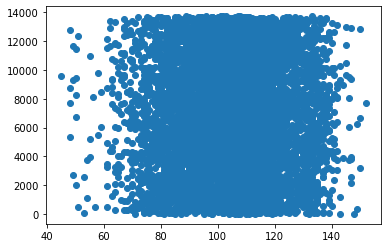

In [30]:
x = df['iq'].to_numpy()
y = df['X'].to_numpy()
plt.scatter(x,y)
plt.show()

Looking into negative correlation from dep_score and others

Dep_score = Child's depression score on CIS-R at 17.5 years old.

Columns thought to be negatively correlated:

musi_week = Average time child spent per day playing musical instruments on a typical weekday

musi_wend = Average time child spent per day playing musical instruments on a typical weekend day

read_week = Average time child spent per day reading books for pleasure on a typical weekday

read_wend = Average time child spent per day reading books for pleasure on a typical weekend day

out_sum_week = Average time child spent per day out of doors in summer on a typical weekday

out_sum_wend = Average time child spent per day out of doors in summer on a typical weekend day

out_win_week = Average time child spent per day out of doors in winter on a typical weekday

out_win_wend = Average time child spent per day out of doors in winter on a typical weekend day

In [5]:
columns = ['dep_score', 'musi_week', 'musi_wend', 
           'read_week', 'read_wend', 'out_sum_week', 
           'out_sum_wend', 'out_win_week', 'out_win_wend']

In [9]:
df3 = df[columns]
df3.head()

,dep_score,musi_week,musi_wend,read_week,read_wend,out_sum_week,out_sum_wend,out_win_week,out_win_wend
0,0.0,Not at all,Not at all,Less than 1 hour,Less than 1 hour,3 or more hours,3 or more hours,3 or more hours,3 or more hours
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Not at all,Not at all,1 or more hours,1 or more hours,Less than 3 hours,Less than 3 hours,Less than 1 hour,Less than 1 hour


In [10]:
# Shamelessly stolen from Isabella
# replace nan with -1 -> to keep them recognisable
df3 = df3.fillna(-1)

# make all columns a category -> even the numerical ones as they are not continous numbers
df3 = df3.astype('category')
# use pd's codes to make them numeric -> -1 disappears this way
df = df3.apply(lambda x: x.cat.codes)
df.columns

Index(['dep_score', 'musi_week', 'musi_wend', 'read_week', 'read_wend',
       'out_sum_week', 'out_sum_wend', 'out_win_week', 'out_win_wend'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13734 entries, 0 to 13733
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   dep_score     13734 non-null  int8 
 1   musi_week     13734 non-null  int8 
 2   musi_wend     13734 non-null  int8 
 3   read_week     13734 non-null  int8 
 4   read_wend     13734 non-null  int8 
 5   out_sum_week  13734 non-null  int8 
 6   out_sum_wend  13734 non-null  int8 
 7   out_win_week  13734 non-null  int8 
 8   out_win_wend  13734 non-null  int8 
dtypes: int8(9)
memory usage: 120.8 KB


<AxesSubplot:xlabel='out_win_wend', ylabel='dep_score'>

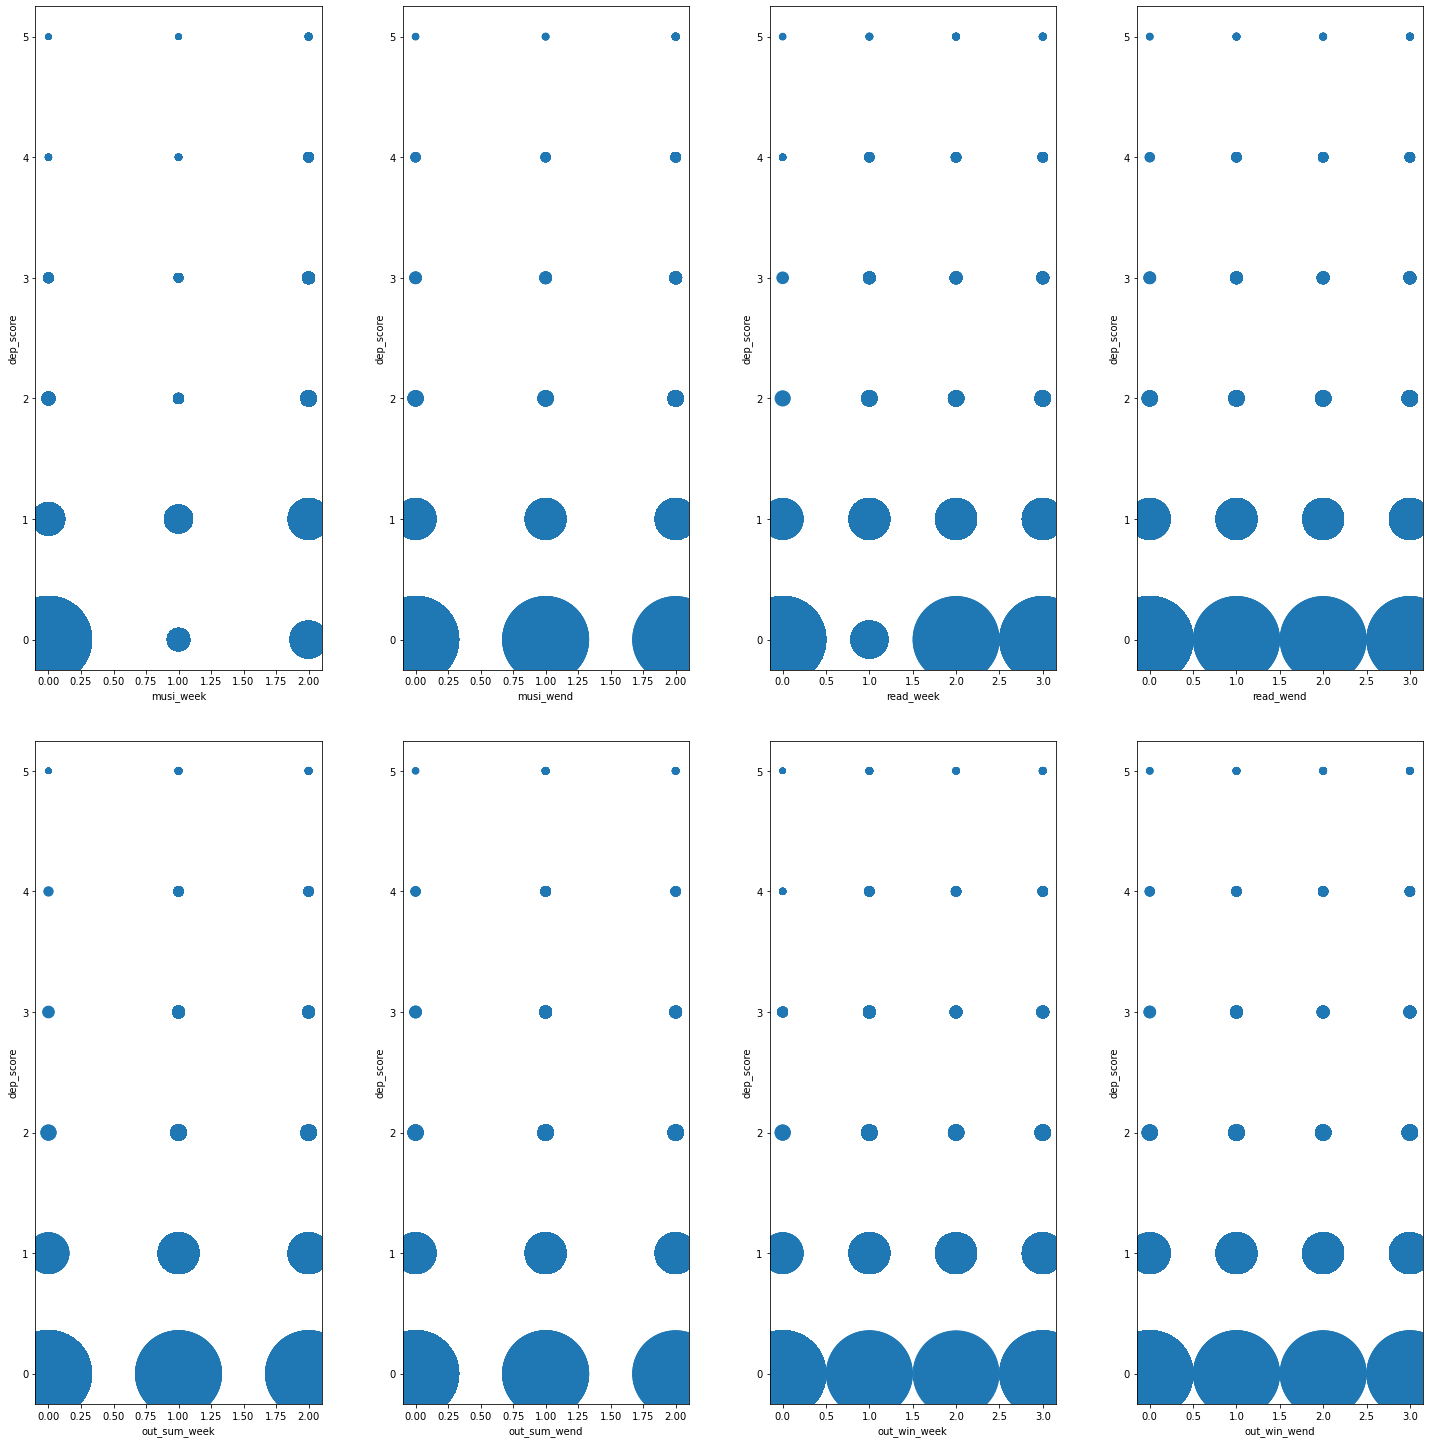

In [49]:
x = df['dep_score']

# plt.rcParams["figure.figsize"] = [20, 20]

fig, axes = plt.subplots(nrows=2, ncols=4)
fig.tight_layout(h_pad=5, w_pad=5)


df.plot(kind='scatter', x='musi_week',y='dep_score',s=calc_s(x,y), ax=axes[0,0])
df.plot(kind='scatter', x='musi_wend',y='dep_score',s=calc_s(x,y), ax=axes[0,1])
df.plot(kind='scatter', x='read_week',y='dep_score',s=calc_s(x,y), ax=axes[0,2])
df.plot(kind='scatter', x='read_wend',y='dep_score',s=calc_s(x,y), ax=axes[0,3])

df.plot(kind='scatter', x='out_sum_week',y='dep_score',s=calc_s(x,y), ax=axes[1,0])
df.plot(kind='scatter', x='out_sum_wend',y='dep_score',s=calc_s(x,y), ax=axes[1,1])
df.plot(kind='scatter', x='out_win_week',y='dep_score',s=calc_s(x,y), ax=axes[1,2])
df.plot(kind='scatter', x='out_win_wend',y='dep_score',s=calc_s(x,y), ax=axes[1,3])

# plt.scatter(x, y, s=calc_s(x,y))
# plt.show()

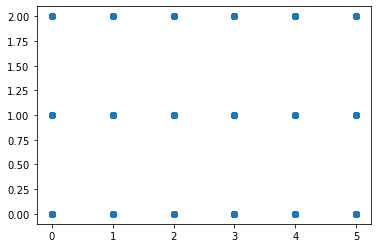

In [18]:
y = df['musi_wend']
plt.scatter(x,y)
plt.show()

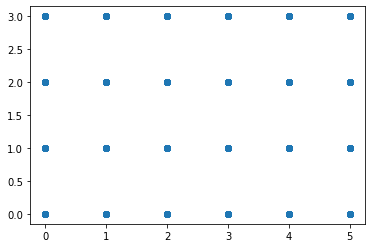

In [19]:
y = df['read_week']
plt.scatter(x,y)
plt.show()

In [20]:
cov_matrix = df.cov()
cov_matrix.head()

,dep_score,musi_week,musi_wend,read_week,read_wend,out_sum_week,out_sum_wend,out_win_week,out_win_wend
dep_score,0.739026,0.265108,0.257157,0.351147,0.340661,0.231853,0.190011,0.315783,0.299664
musi_week,0.265108,0.745933,0.703997,0.881337,0.848901,0.545781,0.449642,0.749282,0.715987
musi_wend,0.257157,0.703997,0.730056,0.848593,0.863679,0.526844,0.457864,0.725898,0.727402
read_week,0.351147,0.881337,0.848593,1.338274,1.248148,0.711709,0.589937,0.989988,0.942528
read_wend,0.340661,0.848901,0.863679,1.248148,1.325653,0.678600,0.593734,0.946771,0.948102


<AxesSubplot:>

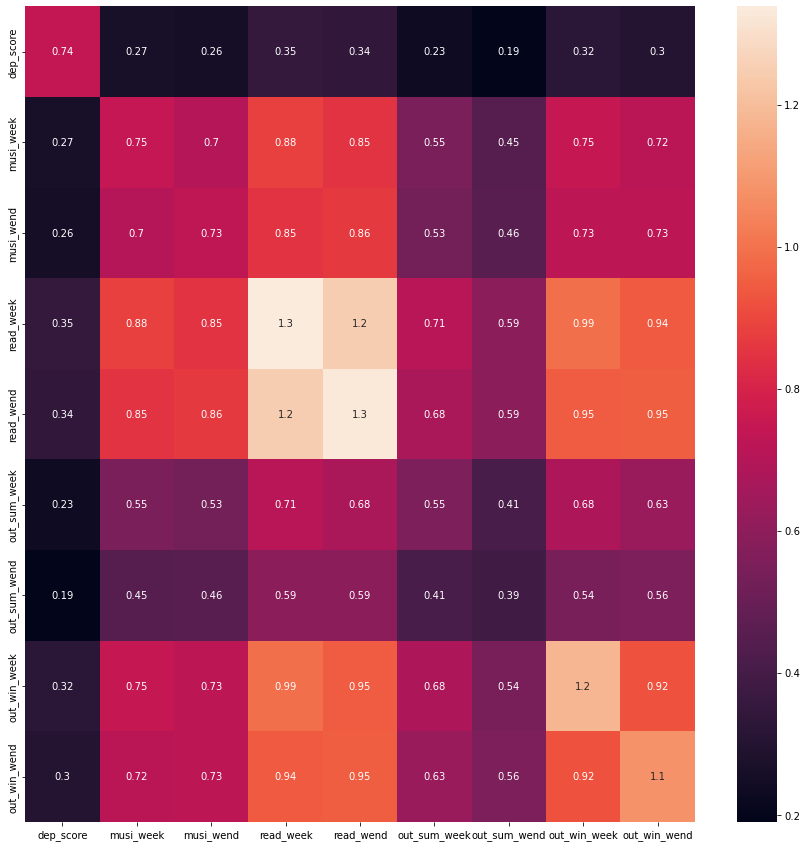

In [21]:
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 15]
sns.heatmap(cov_matrix, annot=True)

<AxesSubplot:>

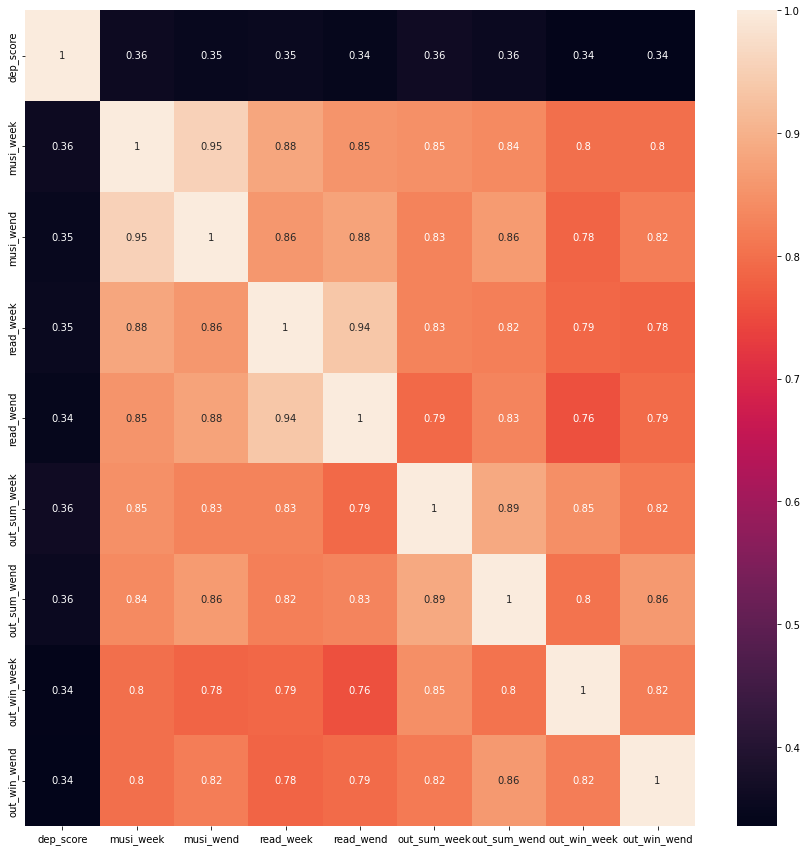

In [22]:
# Correlation matrix
corr_matrix = df.corr()
plt.rcParams["figure.figsize"] = [15, 15]
sns.heatmap(corr_matrix, annot=True)